<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jcc/02-Word2Vec%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec+LSTM

En esta notebook, se entrena y prueba la clasificación de oraciones usando LSTM y Word2Vec pre-entrenado.

El principal beneficio de la incrustación de palabras es que incluso las palabras que no se ven durante el entrenamiento se pueden predecir bien ya que la incrustación de palabras está pre-entrenada con un conjunto de datos más grande que los del dataset actual.


## Instalación y Carga de librerías, modelo word2vec pre-entrenado y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install gensim
!pip install requests
!pip install wget

### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/JCC/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, separar_x_y_rna

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/JCC/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos, get_max_length

### Carga del modelo de embeddings pre-entrenado que se va a utilizar

Se trabaja con tres modelos de embeddings: Word2Vec, Glove y FastText.

__Referencias:__ https://github.com/dccuchile/spanish-word-embeddings.

In [4]:
from os import path
import gensim

EMBEDDINGS = 'Word2Vec'

if EMBEDDINGS == 'Word2Vec':
  PATH_EMBEDDINGS = 'http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz'
  FILENAME_EMBEDDINGS = "SBW-vectors-300-min5.bin.gz"
  DIM_EMBEDDINGS = 300

# Se descarga solo si no están en el working directory. Size ~= 1gb
if not(path.exists(FILENAME_EMBEDDINGS)):
  import wget
  wget.download(PATH_EMBEDDINGS)

# Cargo el modelo de embeddings
from gensim.models import Word2Vec
embeddings = gensim.models.KeyedVectors.load_word2vec_format(FILENAME_EMBEDDINGS, binary=True)
# Se normalizan los pesos de los vectores
embeddings.init_sims(replace=True)

### Se cargan funciones que se utilizan para el pre-procesamiento de las secuencias

In [5]:
def embed(texts, dim_embeddings):
  """
  devuelve un tensor de tensores con los embedding de las palabras
  para usar en la red LSTM
  """
  import tensorflow as tf
  import numpy as np

  # Inicializo el tensor principal con un array de (1, dim_embeddings) de ceros
  tensor_principal = tf.convert_to_tensor(np.zeros((1, dim_embeddings)), dtype=tf.float32)
  iteration = 0
  for word in texts:  
    try:
      e = tf.convert_to_tensor(np.reshape(embeddings.get_vector(word), (1, dim_embeddings)), dtype=tf.float32)
    except:
      e = tf.convert_to_tensor(np.zeros((1, dim_embeddings)), dtype=tf.float32)
    if iteration==0:
      tensor_principal = e
    else:
      tensor_principal = tf.concat([tensor_principal, e], 0)
    iteration = iteration+1
    
  return tensor_principal


def get_word2vec_enc(texts, dim_embeddings):
    """
    recibe todos los textos y devuelve una array numpy de tensores de correos
    cada tensor tiene tensores con el embedding de cada palabras
    """
    encoded_texts = []
    for text in texts:
        tokens = text.split(" ")
        word2vec_embedding = embed(tokens, dim_embeddings)
        encoded_texts.append(word2vec_embedding)
    return encoded_texts
        
def get_padded_encoded_text(encoded_text, max_length, dim_embeddings):
    """
    para frases cortas se rellena con ceros el array a efectos de contar con la
    misma longitud
    """
    import numpy as np

    padded_text_encoding = []
    for enc_text in encoded_text:

        zero_padding_cnt = max_length - enc_text.shape[0]
        pad = np.zeros((1, dim_embeddings))
        for i in range(zero_padding_cnt):
            enc_text = np.concatenate((pad, enc_text), axis=0)
        padded_text_encoding.append(enc_text)
    return padded_text_encoding

def category_encode(category):
    """
    Se encodea la clase en variables dummies
    """
    import pandas as pd

    return pd.get_dummies(category)


def preprocess(x, y, max_length, dim_embeddings):
    """
    se encodean x e y llamando a las funciones get_word2_vec_enc, 
    get_padded_encoded_text y category_encode
    """
    import numpy as np
    # encode words into word2vec
    text = x.tolist()
    
    encoded_text = get_word2vec_enc(text, dim_embeddings)
    padded_encoded_text = get_padded_encoded_text(encoded_text, max_length, dim_embeddings)
    
    # encoded class
    encoded_category = category_encode(y)
    X = np.array(padded_encoded_text)
    Y = np.array(encoded_category)
    return X, Y 

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = 4

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/consolidado_jcc/'
TRAIN_FILE = 'correos-train-80.csv'
TEST_FILE = 'correos-test-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()
train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['Consulta'] = pd.Series(preprocesar_correos(train_df['Consulta']))
test_df['Consulta'] = pd.Series(preprocesar_correos(test_df['Consulta']))

# Separo en train y test
x_train, y_train = separar_x_y_rna(train_df, 'Consulta', 'clase')
x_test, y_test = separar_x_y_rna(test_df, 'Consulta', 'clase')


El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)


## Preprocesamiento (codificación del texto a vectores numéricos)

In [7]:
# Largo máximo de las consultas
max_length = get_max_length(x_train)

# Preproceso las secuencias de texto
x_train_processed, y_train_processed = preprocess(x_train, y_train, max_length, DIM_EMBEDDINGS)
x_test_processed, y_test_processed = preprocess(x_test, y_test, max_length, DIM_EMBEDDINGS)

In [8]:
print('DIM de x_train: {}x{}x{}.'.format(len(x_train_processed), len(x_train_processed[0]), len(x_train_processed[0][0])))

DIM de x_train: 800x43x300.


## Construcción del Modelo

### Generador de números aleatorios

Se setea de manera fija la semilla para el generador de números aleatorios a efectos de que los experimentos sean reproducibles.

In [9]:
import tensorflow as tf
tf.random.set_seed(1)

### Arquitectura de LSTM

Se define la arquitectura de la red LSTM:

In [10]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

# Arquitectura del modelo LSTM
model = Sequential()
model.add(LSTM(300))
model.add(Dense(CANTIDAD_CLASES, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Entrenamiento del modelo

In [11]:
print('Train...')
lstm_model = model.fit(x_train_processed, 
                       y_train_processed, 
                       batch_size=64, 
                       epochs=25, 
                       verbose=1, 
                       validation_data=(x_test_processed, y_test_processed))

Train...
Epoch 1/25
13/13 [==============================] - 7s 405ms/step - loss: 1.3317 - accuracy: 0.4171 - val_loss: 1.2326 - val_accuracy: 0.4650
Epoch 2/25
13/13 [==============================] - 4s 335ms/step - loss: 1.1868 - accuracy: 0.5147 - val_loss: 0.9160 - val_accuracy: 0.6600
Epoch 3/25
13/13 [==============================] - 4s 334ms/step - loss: 0.8839 - accuracy: 0.6655 - val_loss: 0.8824 - val_accuracy: 0.6750
Epoch 4/25
13/13 [==============================] - 4s 339ms/step - loss: 0.9254 - accuracy: 0.6512 - val_loss: 0.9259 - val_accuracy: 0.7100
Epoch 5/25
13/13 [==============================] - 5s 331ms/step - loss: 0.8278 - accuracy: 0.7237 - val_loss: 0.7198 - val_accuracy: 0.6950
Epoch 6/25
13/13 [==============================] - 4s 330ms/step - loss: 0.6769 - accuracy: 0.7255 - val_loss: 0.6491 - val_accuracy: 0.7650
Epoch 7/25
13/13 [==============================] - 4s 336ms/step - loss: 0.5981 - accuracy: 0.7798 - val_loss: 0.6889 - val_accuracy: 0.75

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 4)                 1204      
Total params: 722,404
Trainable params: 722,404
Non-trainable params: 0
_________________________________________________________________


### Testeo del Modelo

In [13]:
results = model.evaluate(x_test_processed, y_test_processed, batch_size=128)

2/2 [==============================] - 0s 122ms/step - loss: 0.6232 - accuracy: 0.7950


### Gráfico de la evolución de epochs vs accuracy/loss

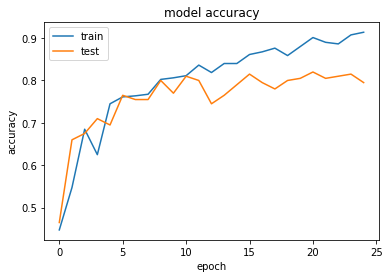

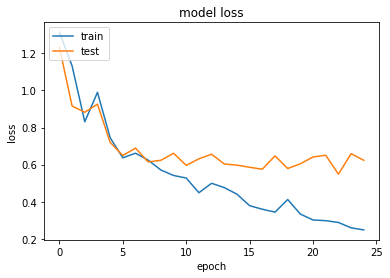

In [14]:
import matplotlib.pyplot as plt

plt.plot(lstm_model.history['accuracy'])
plt.plot(lstm_model.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model.history['loss'])
plt.plot(lstm_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()